In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Boundary Layer Solver

This notebook will develop a numerical method for solving the boundary layer momentum integral equation using Pohlhausen velocity profiles.

## Momentum integral equation

In the boundary layer portion of the course we derived the governing equations for a boundary layer using the concept of a velocity profile 

$$u = u_e(x) f(\eta), \quad \eta=\frac y{\delta(x)}$$

where $u_e$ is the local free stream velocity and $\delta$ is the boundary layer thickness. Note that $x$ is the distance along the wall from the leading edge and $y$ is the distance from the wall.

---
![Boundary layer profile](resources/graphics4.png)

---

Integrating the Prandtl momentum equation through the boundary layer thickness resulted in the **momentum integral equation**

$$ \frac 12 c_f = \frac{u_e'}{u_e}(\delta_1+2\delta_2)+\delta_2' $$

This equation balances the local wall friction with the change in the boundary layer profile properties. The tick mark indicates a derivative, ie $u_e'=\frac{du_e}{dx}$. 

** The goal is to use the momentum equation to determine how the boundary layer develops, predicting the friction drag and the point of separation. **

The velocity $u_e$ (and $u_e'$) is considered to be prescribed by the potential flow solution, but there are still too many unknowns. We need to choose a profile to develop this further...

##Pohlhausen profile

The Pohlhausen profile is used to describe a **laminar** velocity profile exposed to external pressure gradients. The profile is defined as

$$ \frac u {u_e} = f(\eta,\lambda) = P_F(\eta)+\lambda P_G(\eta) $$

where $\lambda$ is the *shape factor*, given by
$$ \lambda = \frac {\delta^2}\nu u_e'$$

and the profile shapes are defined by

- $ P_F = 2\eta-2\eta^3+\eta^4 $ is the flat plate profile
- $ P_G = \frac\eta 6 (1-\eta)^3 $ is the modification for pressure gradients

These can be easly defined using a set of python functions

In [2]:
import numpy

def pohlF(eta): return 2*eta-2*eta**3+eta**4
def pohlG(eta): return eta/6*(1-eta)**3

In [3]:
from matplotlib import pyplot
%matplotlib inline

def pohlPlot(lam):
    pyplot.xlabel(r'$u/u_e$', fontsize=16)
    pyplot.axis([-0.1,1.1,0,1])
    pyplot.ylabel(r'$y/\delta$', fontsize=16)
    eta = numpy.linspace(0.0,1.0,100)
    pyplot.plot(pohlF(eta),eta, lw=1, c='k', label=r'$P_F$')
    pyplot.plot(pohlF(eta)+lam*pohlG(eta),eta, lw=2, c='g', label=r'$P_F+\lambda P_G$')
    pyplot.legend(loc='upper left')

Change $\lambda$ below to see its effect on the profile shape.

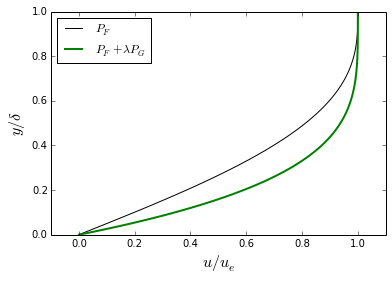

In [4]:
pohlPlot(lam=12)

##### Quiz 1

What value of $\lambda$ denotes separated flow?

1. $\lambda$<-12
1. $\lambda$=0
1. $\lambda$>12

---

Using the Pohlhausen profile, the various factors in the momentum integral equation are defined as

- $\frac{\delta_1}\delta = \int_0^1 (1-f) d\eta = \frac3{10}-\lambda\frac1{120}$


- $\frac{\delta_2}\delta = \int_0^1 f(1-f) d\eta = \frac{37}{315}-\lambda\frac1{945}-\lambda^2\frac1{9072}$


- $\frac 12 c_f Re_\delta =f'_0= 2+\lambda\frac1{6}$

where $Re_\delta = \frac{u_e\delta}\nu$ is the local boundary layer Reynolds number. 

In [5]:
def disp_ratio(lam): return 3./10.-lam/120.
def mom_ratio(lam): return 37./315.-lam/945.-lam**2/9072.
def df_0(lam): return 2+lam/6.

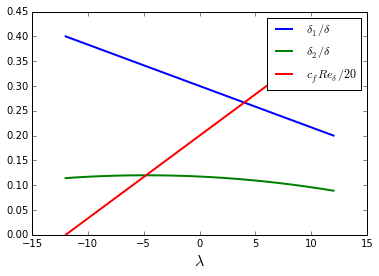

In [6]:
pyplot.xlabel(r'$\lambda$', fontsize=16)
lam = numpy.linspace(-12,12,100)
pyplot.plot(lam,disp_ratio(lam), lw=2, label=r'$\delta_1/\delta$')
pyplot.plot(lam,mom_ratio(lam), lw=2, label=r'$\delta_2/\delta$')
pyplot.plot(lam,df_0(lam)/10., lw=2, label=r'$c_f Re_\delta/20$')
pyplot.legend(loc='upper right')

Note that these are all polynomial functions of $\lambda$. **Since $u_e$ is given by potential flow and $\lambda = \frac {\delta^2}\nu u_e'$, the only unknown in the momentum equation is now $\delta(x)$!**

## Stagnation point condition

Now we need to write the momentum equation in terms of $\delta$ (and $\lambda$) and solve. This equation needs to be valid from the leading edge all the way to the point of separation. 

For any body with finite thickness the boundary layer will begin at the stagnation point at the front of the body. However, describing the boundary layer at a stagnation point is somewhat tricky.

![Stagnation point](resources/stagnation.png)

##### Quiz 2

Which relationships are true at a stagnation point?

1. $u_e = 0$
1. $u_e' = 0$
1. $\delta/x << 1$
1. $c_f$ is singular

---

That's no good - the momentum equation will be singular at the leading edge.  We can avoid this problem by multiplying the whole equation by $Re_\delta$, leading to:

$$ \frac 12 c_f Re_\delta = \frac\delta\nu u_e' [\delta_1+2\delta_2]+Re_\delta \delta_2'$$ 

The first term on the RHS can be simplified by dividing the brackets by $\delta$ and mutiplying by $\delta$ outside out to produce the definition of $\lambda$. This lets us group the terms only dependant on $\lambda$ together to define

$$ g_1(\lambda) = \frac 12 c_f Re_\delta - \lambda \left[\frac{\delta_1}{\delta}+2\frac{\delta_2}\delta\right]$$

In [7]:
def g_1(lam): return df_0(lam)-lam*(disp_ratio(lam)+2*mom_ratio(lam))

Using this definition, the momentum equation is

$$ g_1(\lambda) = Re_\delta \delta_2'$$ 


##### Quiz 3

The equation above further simplifies at the stagnation point. Which is correct?

1. $g_1 = 0$
1. $g_1 = Re_\delta$
1. $ \frac 12 c_f = 0$

---

Solving this equations will determine our *initial condition* $\lambda_0$. Using my vast [google skills](http://lmgtfy.com/?q=numpy+find+root&l=1) I found the `bisect` function in `scipy.optimize` which will solve for the root.

In [8]:
from scipy.optimize import bisect
lam0 = bisect(g_1,-12,12)
print('lambda_0 = '+'%.3f'%lam0)

lambda_0 = 7.052


With the value of $\lambda_0$ determined, the initial condition $\delta_0$ is simply

$$ \delta_0 = \sqrt{\frac{\nu \lambda_0}{u_e'(x_0)}} $$

## Pohlhausen evolution equation

The only thing left to do is write $\delta_2'$ in terms of $\delta'$. Using $F=\frac{\delta_2}\delta$ we have

$$ \delta_2' = \frac{d}{dx}(F\delta) $$

From the line plot above, we see that $F$ is nearly unchanged across the whole range of $\lambda$, so we will treat it as a constant. Therefore the complete Pohlhausen momentum equation is

$$ g_1 = Re_\delta F \delta'$$

Isolating the derivative, we have

$$ \delta'= \frac{g_1(\lambda)}{Re_\delta F(\lambda)} $$

In [9]:
def ddx_delta(Re_d,lam):
    if Re_d==0: return 0                     # Stagnation point condition
    return g_1(lam)/mom_ratio(lam)/Re_d      # delta'

Lets plot the functions of  $\lambda$ to get a feel for how the boundary layer will develop.

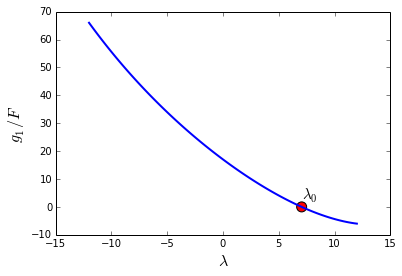

In [10]:
pyplot.xlabel(r'$\lambda$', fontsize=16)
pyplot.ylabel(r'$g_1/F$', fontsize=16)
pyplot.plot(lam,ddx_delta(1,lam), lw=2)
pyplot.scatter(lam0,0, s=100, c='r')
pyplot.text(lam0,3, r'$\lambda_0$',fontsize=15)

##### Quiz 4

What will happen if $\lambda>\lambda_0$?

1. Flat plate boundary layer flow.
1. The boundary layer will shrink.
1. The Pohlausen equation will be singular.

## Ordinary differential equations

The $\delta$ evolution equation above is an ordinary differentilal equation (ODE), having the form

$$ \delta' = g(\delta(x),x) $$

where the derivative is only a function of the variable and one indepentant variable $x$. All ODEs have an important feature in common:

##### Mathematics fundamental: ODEs
##### Systems' whose evolution depends only on their current state 

This makes them easier to solve. If we integrate the ODE from $x_0$ to $x_1$ we have

$$ \delta(x_1) = \delta_1= \delta_0+\int_{x_0}^{x_1} g(\delta(x),x) dx $$

which means all we need to solve for $\delta_1$ is the initial condition $\delta_0$ and an estimate the RHS integral. And once we have $\delta_1$, we can get $\delta_2$, etc. In general we have

$$ \delta_{i+1}= \delta_i+\int_{x_i}^{x_{i+1}} g(\delta(x),x) dx  \quad i=0,\ldots, N-1$$

This means the ODE can be solved by *marching* from $x=0$ to $x=L$. Compare this to the vortex panel method and its linear system of equations that needed to be solved simultaneously using matrices... This is easy.

## Boundary layer module

I have implemented a function `march` to solve the boundary layer ODE defined by `ddx_delta` above. It is found in the BoundaryLayer.py file. Let's import and test it:

In [20]:
from BoundaryLayer import march
help(march)

Help on function march in module BoundaryLayer:

march(x, u_e, nu)
    # march along boundary layer from stagnation to separation:
    # return the boundary layer thickness, shape function,
    # and separation index



where `x`=$x$ and `u_e`=$u_e(x)$ are arrays holding the distance along the boundary layer and the external velocity, and `nu`=$\nu$ is the kinematic viscosity.

A few notes:

- The initial condition must be a stagnation point. If `u_e[0]>0` then we assume the stagnation point is at $x=0$ and integrate from $x=0\ldots$`x[0]`.

- The function breaks out of the marching loop if the flow separates ($\lambda<-12$) and return the final index `i` along with the `delta`=$\delta$ and `lam`=$\lambda$ arrays. 

---



##### Your turn #1

Use flat plate theory to test the `march` function:

- ** Define ** the inputs to `march` for a flat plate with $L=1$, $U_\infty=1$, and $Re_L=10^5$.
- ** Plot and compare ** the boundary layer thickness againt the analytic Pohlhausen flat plate solution 
$$\frac\delta L=\frac{5.836}{\sqrt{Re_x}}\frac xL$$.

##### Solution #1

In [16]:
N=32

#x = ??
#u_e = ??
#nu = ??

#delta,lam,iSep = march(x,u_e,nu)       # solve!

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


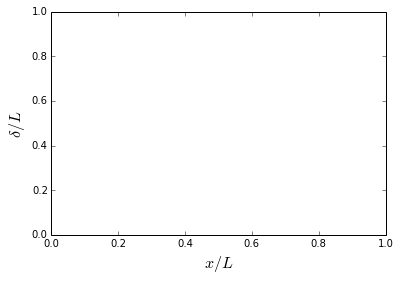

In [17]:
pyplot.ylabel(r'$\delta/L$', fontsize=16)
pyplot.xlabel(r'$x/L$', fontsize=16)
pyplot.legend(loc='upper left')

#pyplot.plot(x,5.836*numpy.sqrt(nu*x),lw=2,label='analytic')

# your code here

---

## Friction force

On a flat plate, the Pohlhausen friction drag coefficient is simply given by $C_F = 1.33/\sqrt{Re_L}$. Let's use this analytic result to further validate our method. 

The local wall friction stress is given by

$$ \tau_w = \frac 12 c_f \rho u_e^2 $$

Note that this is scaled by $u_e^2$, not $U_\infty^2$.

This stress can be integrated over the boundary layer to give the total friction force

$$F_f = \int_0^L \tau_w dx$$ 

Therefore the total friction drag coefficient is given as

$$C_F = \frac{F_f}{\tfrac 12 \rho U_\infty^2 L } = \frac{\int_0^L \tau_w dx}{\tfrac 12 \rho U_\infty^2 L }$$ 

##### Your turn #2

- ** Write ** $\tau_w/\rho$ as a function of $u_e$, $\delta$, $\lambda$ and $\nu$.
- ** Complete ** the $\tau_w/\rho$ function and plot the results for the flat plate.
- ** Complete ** the $C_F$ function using the integral equation.
- ** Compare ** the function output to the flat plate analytic solution $C_F = 1.33/\sqrt{Re_L}$

##### Solution #2

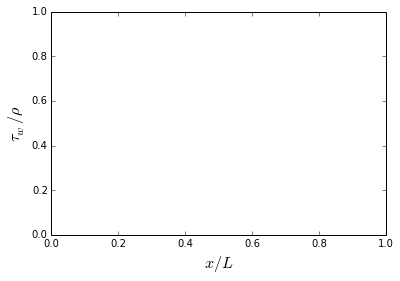

In [18]:
def tau_w(u_e,delta,lam,nu):  # really tau_w/rho
    # your code here
    return tau_w

pyplot.ylabel(r'$\tau_w/\rho$', fontsize=16)
pyplot.xlabel(r'$x/L$', fontsize=16)
# your code here

In [19]:
def C_F(u_e,delta,lam,nu,x):
    # your code here
    return C_F

#print('Analytic: C_F = '+'%.3e' % (1.33*numpy.sqrt(nu)))
#print('Numeric:  C_F = '+'%.3e' % C_F(u_e,delta,lam,nu,x))